**Question/need:** Can we predict the success (gross revenues, revenues per budget dollar, and/or oscar nominations) of proposed low-budget films (< $10 million) based on its characteristics? Are there different predictive characteristics for success in terms of gross revenues vs. oscar nominations? 

**Movie data:** I'm planning on using all movies (1980 - 2016) from boxofficemojo to investigate the impact of various characteristics on success. If I have time, I would also like to incorporate other variables, such as google searches and wikipedia page views, as well as critic and general public rating information from rottentomatoes. 

**Characteristics of each movie and/or other entities:** I'd like to investigate as many characteristics as possible during my first pass to determine which ones have the greatest predictive impact, and then dig in deeper to these characteristics. The features I'm most interested in are: genre, release date (month, if before a holiday weekend, if during Christmas holiday, if during summer), star power (a score that accounts for actors, director, and producers), production budget, and if there the movie has some preexisting popularity, either through a novel/play adaptation or if there's a prequel. I'll also investigate other features such as runtime, rating, and franchise, but I have a hunch that these will have a smaller impact. 

In [542]:
'''TO DOS:
- clean up genres and rating
- adjust budget for inflation'''

'TO DOS:\n- clean up genres and rating\n- adjust budget for inflation'

In [1183]:
# storing
import pickle

# exploratory analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from pandas.tools.plotting import scatter_matrix

# regression
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

from pprint import pprint

%matplotlib inline

### parse data

First, let's load the movie data into a dataframe and check the quality of our data.

In [691]:
with open('pickled_data/all-movies-data3.pkl', 'r') as picklefile:
    all_movies_data = pickle.load(picklefile)

In [688]:
movies = pd.DataFrame(all_movies_data)

Time to do some cleaning...

In [693]:
# rename cols
movies.rename(columns = {'1-title': 'title', 
                         '2-release_date': 'release_date', 
                         '3-closing_date': 'closing_date'}, inplace = True)

In [743]:
# split actor, director, producer, writer columns
def get_person(peoplelist, i):
    '''Take a list of people and inde; return person at that index. Return blank if no list present.'''
    try:
        return peoplelist[i]
    except:
        return ''

def sep_people(df, person_type, num_people):
    '''For each column with list of people, split into n columns with one person in each column.
    Name new columns as person_type + n.
    
    Args:
    df -- name of dataframe
    person_type -- name of column (str)
    num_people -- number of columns to generate
    '''
    for n in range(num_people):
        df.loc[:, person_type + str(n+1)] = df.loc[:, person_type].apply(get_person, args=(n,))

# add seasons; rationale from http://www.boxofficemojo.com/seasonal/?chart=byseason
def get_season(date):
    '''Return season given month as int.'''
    months = (range(1, 13))
    seasons = ['winter', 'winter', 'spring', 'spring', 
           'summer', 'summer', 'summer', 'summer', 
           'fall', 'fall', 'holiday', 'holiday']
    seasons = dict(zip(months, seasons))
    try:
        return seasons[date.month]
    except:
        return ''
       
def recat(df, func, new_col, old_col):
    '''Recategorize variable in new column based on data in old col
    and provided function. 
    Args: 
    df -- data frame
    func -- function to apply
    new_col (str) -- name of new column (to store result of function)
    old_col (str) -- name of old column (on which to apply function)
    '''
    df[new_col] = df.loc[:, old_col].apply(func) 

# map raw genres to simple genres
def get_simple_genre(g):
    '''Recategorize raw genre into simple genre.'''
    raw_genres = tuple(by_genre.count().index)
    simple_genres = ['Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Animation', 'Comedy', 'Comedy', 'Comedy', 'Other', 
                 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 
                 'Documentary', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Foreign', 'Foreign', 'Foreign', 'Historical', 'Historical', 
                 'Horror', 'Horror', 'Horror', 'Other', 'Musical', 'Musical', 'None', 
                 'Historical', 'Historical', 'Historical', 'Historical', 'Historical', 
                 'Romance', 'Romance', 'Romance', 'Romance', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Sports', 'Sports', 'Sports', 'Sports',  'Crime_Thriller', 
                 'None', 'War', 'War', 'War', 'Western', 'Western']
    try:
        return genres[g]
    except:
        return ''

def add_simple_genre(df):
    df['new_genre'] = df.loc[:, 'genre'].apply(get_simple_genre)
    
# clean up ratings
def get_clean_rating(r):
    rm_ratings = ['Unknown', 'Unrated', 'None', 'Not Yet Rated']
    return '' if r in rm_ratings else r

def clean_rating(df, func, new_col):
    '''Add new column to df with cleaned up rating. 
    Args:
    df -- df to work on
    func -- function to apply
    new col (str) -- name of new column to create for cleaned up rating
    '''
    df[new_col] = df.loc[:, 'rating'].apply(func)
    
# add roi
def add_roi(df):
    df['dom_roi'] = df.loc[:, 'dom_total_gross'] / df.loc[:, 'budget']
    df['intl_roi'] = df.loc[:, 'intl_total_gross'] / df.loc[:, 'budget']
    
# add total time in theaters - not necessary if we have theaters?
def add_in_theaters_time(df):
    try:
        df['time_in_theaters'] = df.loc[:, 'closing_date'] - df.loc[:, 'release_date']
    except:
        df['time_in_theaters'] = ''

In [744]:
sep_people(movies, 'director', 3)
sep_people(movies, 'actors', 5)
sep_people(movies, 'writers', 2)
sep_people(movies, 'producers', 3)
recat(movies, get_season, 'season', 'release_date')
clean_rating(movies, get_clean_rating, 'clean_rating')

In [696]:
add_simple_genre(movies) # try not to rerun this guy, takes a while

In [697]:
# pickle the parsed df
with open('pickled_data/parsed-data3.pkl', 'w') as picklefile:
    pickle.dump(movies, picklefile)

In [699]:
movies.head()

,title,release_date,closing_date,actors,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,...,actors4,actors5,writers1,writers2,producers1,producers2,producers3,season,clean_rating,new_genre
0,The A-Team,2010-06-11,2010-09-16,"[Liam Neeson, Bradley Cooper, Sharlto Copley, ...",110000000,[Joe Carnahan],Fox,77222099,81884600,Action,...,Quinton 'Rampage' Jackson,Jessica Biel,Skip Woods,,Ridley Scott,Tony Scott,Alex Young,summer,PG-13,Act_Adven
1,A.C.O.D.,2013-10-04,2013-11-07,"[Adam Scott, Catherine O'Hara, Richard Jenkins...",NaN,,The Film Arcade,175705,177400,Comedy,...,Clark Duke,Jane Lynch,,,Teddy Schwarzman,,,fall,PG-13,Comedy
2,A.I. Artificial Intelligence,2001-06-29,NaT,"[Haley Joel Osment, Frances O'Connor, Jude Law...",100000000,[Steven Spielberg],Warner Bros.,78616689,117091600,Sci-Fi,...,William Hurt,Brendan Gleeson,,,Kathleen Kennedy,Steven Spielberg,,summer,PG-13,Fantasy_Scifi
3,Aaja Nachle,2007-11-30,2007-12-20,,NaN,,Yash Raj,484108,593200,Foreign,...,,,,,,,,holiday,,Foreign
4,Aarakshan,2011-08-12,2011-09-22,,NaN,,Reliance Big Pictures,651096,691300,Foreign,...,,,,,,,,summer,,Foreign


Since we're interested in budget data, let's check to see how many movies of the 16,100 total movies have budget data.

In [698]:
movies.budget.count()

2875

Only 2,874 out of 16,100 movies have budget data. That's only 17.9% of the entire dataset! Let's take a closer look at movies with budget data.

In [700]:
# drop movies without budget data 
only_budget = movies[pd.notnull(movies['budget'])]

In [708]:
### ONLY APPLICABLE TO MOVIES WITH BUDGETS

# adjust to 2015 dollars 
def get_infl_rate(startyear, endyear):
    '''Return inflation rate to 2015 dollars. 
    Args:
    startyear (float) -- start year
    endyear (int) -- end year
    Returns:
    infl (float) -- inflation rate
    '''
    cpi = pd.read_csv('cpi-data.csv')
    cpi.set_index('YEAR', inplace = True)
    if endyear > 2015:
        return float('NaN')
    else:
        try:
            cpiend = float(cpi.loc[endyear, 'AVE.'])
            cpistart = float(cpi.loc[int(startyear), 'AVE.'])
            infl = ((cpiend - cpistart) / cpistart) 
            return (1.0 + infl)
        except:
            return float('NaN')
    
def add_infl_rate(df):
    # add release year
    try:
        df['release_year'] = df['release_date'].apply(lambda x: x.year)
    except:
        df['release_year'] = None
    df['infl_rate'] = df['release_year'].apply(get_infl_rate, args=(2015,))
    
def add_adj_budget(df):
    df['budget_adj'] = df.loc[:, 'budget'] * df.loc[:, 'infl_rate']
    df['budget_adj'] = df['budget_adj'].fillna(0.0).astype(int)

# add roi calculations
def get_dom_roi(df):
    df['dom_roi'] = (df.loc[:,'dom_total_gross'] - df.loc[:,'budget'])/ df.loc[:,'budget']

def get_intl_roi(df):
    df['intl_roi'] = (df.loc[:,'intl_total_gross'] - df.loc[:,'budget'])/ df.loc[:,'budget']

In [709]:
add_infl_rate(only_budget)
add_adj_budget(only_budget)
get_dom_roi(only_budget)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

Let's look at lower budget movies that have been released in the past 15 years. 

In [703]:
# set assumptions
budget_threshold = 30000000
year_threshold = '1990'

In [704]:
# get only low budget (<$10m) films
low_budget = only_budget[only_budget['budget_adj'] < budget_threshold]
low_budget = low_budget[low_budget['budget_adj'] > 0] # find a better way to write this
low_budget.shape

(1158, 39)

In [705]:
# get only movies since 2000
newer_movies = low_budget[low_budget['release_date'] >= datetime.strptime(year_threshold, '%Y')]
newer_movies.shape

(1085, 39)

### explore high-level features

Season of release vs. mean adjusted domestic total gross. 

In [706]:
def plot_category(cat, y, df):
    '''Make bar plot of categorical features.
    Args: 
    y (str) -- name of column of independent variable
    cat (str) -- name of categorical feature
    df (var) -- name of df'''
    grouped = df.groupby(cat)
    grouped[y].mean().plot(kind = 'bar')
    plt.ylabel('mean %s' %y)
    plt.title('%s vs. %s' %(cat, y))
    plt.show()

def plot_continuous(cat, y, df):
    '''Make scatter plot of continuous features. 
    Args: 
    y (str) -- name of column of independent variable
    cat (str) -- name of categorical feature
    df (var) -- name of df'''
    df.plot(kind = 'scatter', 
             x = cat, 
             y = y, 
             figsize = (8, 5), 
             alpha = 0.5)
    plt.title('%s vs. %s' %(cat, y))
    plt.show()

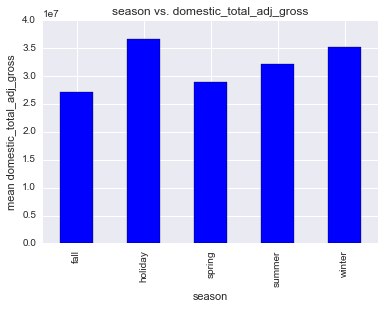

In [707]:
plot_category('season', 'domestic_total_adj_gross', newer_movies)

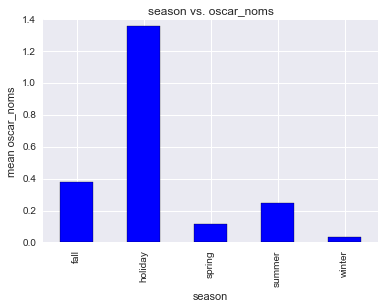

In [560]:
plot_category('season', 'oscar_noms', newer_movies)

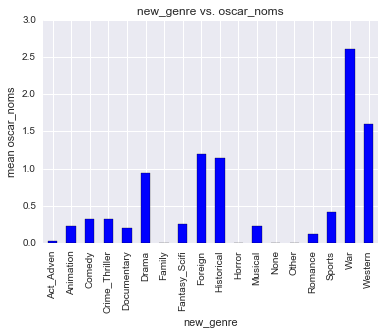

In [638]:
plot_category('new_genre', 'oscar_noms', newer_movies)

Genre vs. mean adjusted domestic total gross. 

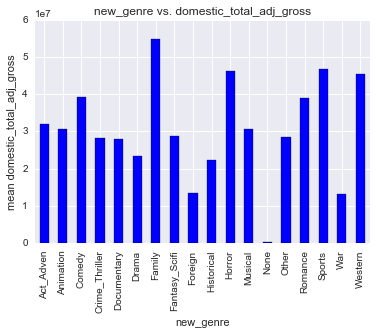

In [639]:
plot_category('new_genre', 'domestic_total_adj_gross', newer_movies)

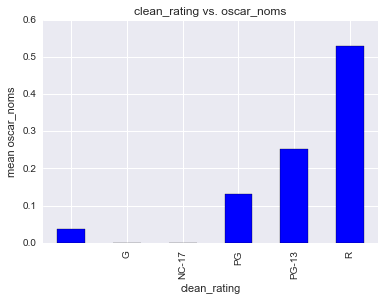

In [652]:
plot_category('clean_rating', 'oscar_noms', train)

Budget vs. domestic total gross.

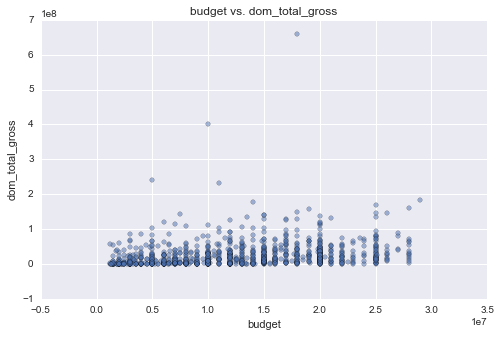

In [565]:
plot_continuous('budget', 'dom_total_gross', newer_movies)

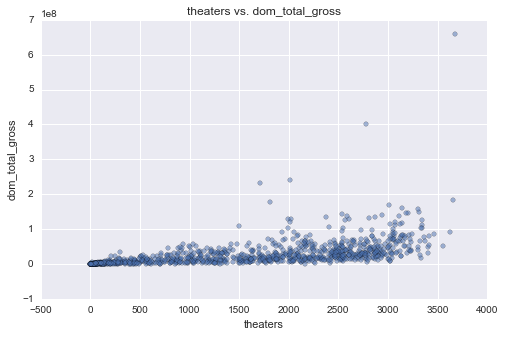

In [566]:
plot_continuous('theaters', 'dom_total_gross', newer_movies)

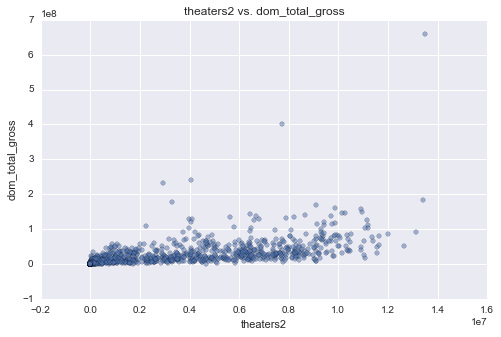

In [1161]:
plot_continuous('theaters2', 'dom_total_gross', newer_movies)

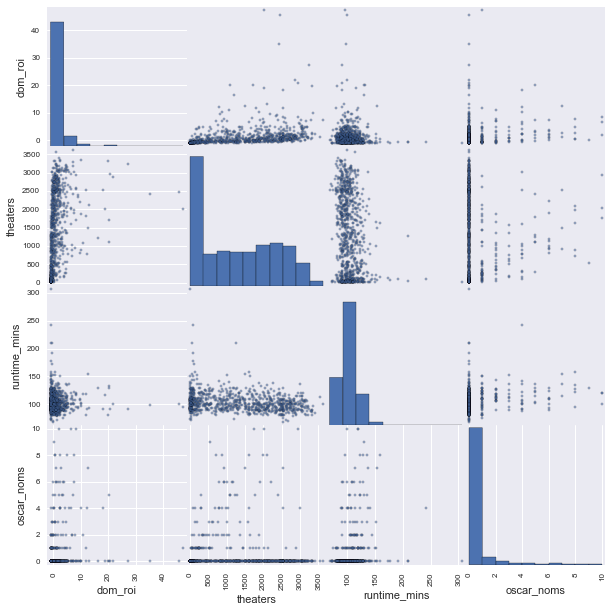

In [1192]:
# plot dom roi vs features 
features = ['dom_roi', 'clean_rating', 'theaters', 'new_genre', 'runtime_mins', 'season', 'oscar_noms']

scatter_matrix(train[features], figsize = (10, 10), alpha = 0.5, diagonal='hist')
plt.show()

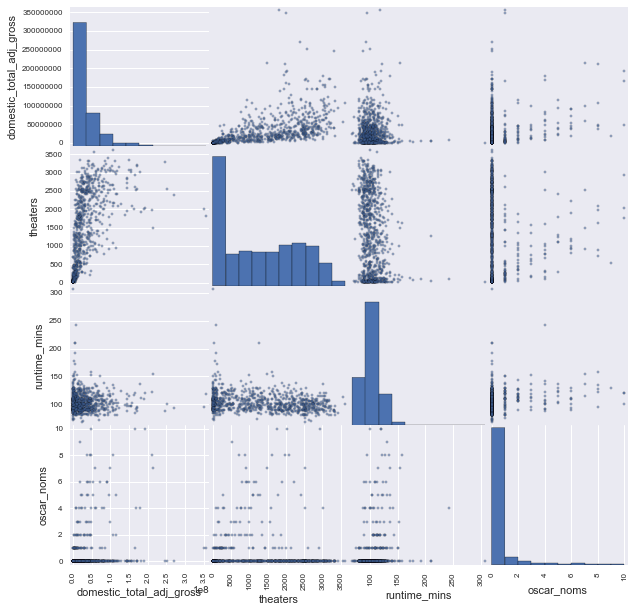

In [1194]:
# plot dom total adj gross vs features 
features = ['domestic_total_adj_gross', 'clean_rating', 'theaters', 'new_genre', 'runtime_mins', 'season', 'oscar_noms']

scatter_matrix(train[features], figsize = (10, 10), alpha = 0.5, diagonal='hist')
plt.show()

### 

### clean up features - oscars

In [1054]:
# clean up oscars model a bit
'''things to clean:
- rating: R vs. not R 
- seasons: holiday, winter, other 
- genres: drama, foreign, historical + need to split other back out...'''

# ratings: split into R and not R
def split_r_rating(r):
    return r if r == 'R' else 'other'

# seasons: split into holiday, winter, and other
def recat_seasons(season):
    rm_seasons = ['spring', 'summer', 'fall']
    return 'other' if season in rm_seasons else season

# genres: split into drama, foreign, historical, war, western, other
def recat_genre(genre):
    keep_genres = ['Drama', 'Foreign', 'Historical', 'Comedy', 'Horror', 'Romance', 'Crime_Thriller']
    return genre if genre in keep_genres else 'other'

# log transform
def log_transform(stat):
    try:
        return math.log(stat)
    except:
        return -1

In [928]:
clean_rating(newer_movies, split_r_rating, 'r_rating')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [929]:
recat(newer_movies, recat_seasons, 'hw_season', 'season')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1000]:
recat(newer_movies, recat_genre, 'recat_genre', 'new_genre')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1055]:
recat(newer_movies, log_transform, 'oscar_noms_log', 'oscar_noms')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### clean up features - roi

In [1137]:
'''Notes:
- theaters have significant correlation, but colinear?
- oscar noms predictive but colinear?
- rating - signficant for everything except nc-17
- genre - significant for horror; maybe romance? keep horror, act_adven, romance, then others

not predictive:
- season
- runtime'''

'''Plot scatter matrix between all variables?'''

def roi_rating(rating):
    rm_rating = ['', 'NC-17']
    return 'other' if rating in rm_rating else rating

def roi_genres(genre):
    keep_genres = ['Horror', 'Act_Adven', 'Documentary']
    return genre if genre in keep_genres else 'other'

In [1162]:
recat(newer_movies, roi_rating, 'roi_rating', 'clean_rating')
recat(newer_movies, roi_genres, 'roi_genre', 'new_genre')
recat(newer_movies, log_transform, 'theaters_log', 'theaters')
recat(newer_movies, log_transform, 'dom_roi_log', 'dom_roi')
recat(newer_movies, lambda x: x**2, 'theaters2', 'theaters')
recat(newer_movies, lambda x: x**3, 'theaters3', 'theaters')
recat(newer_movies, lambda x: x**4, 'theaters4', 'theaters')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1163]:
newer_movies.head()

,title,release_date,closing_date,actors,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,...,recat_genre,oscar_noms_log,roi_rating,roi_genre,theaters_log,theaters^2,theaters2,theaters3,theaters4,dom_roi_log
27,About Last Night,2014-02-14,2014-04-27,"[Kevin Hart, Michael Ealy, Regina Hall, Joy Br...",12500000,[Steve Pink],Sony / Screen Gems,48637684,51495800,Romantic Comedy,...,Romance,-1.000000,R,other,7.720018,5076009,5076009,11436248277,2.576587e+13,1.061608
46,Accepted,2006-08-18,2006-10-19,"[Justin Long, Blake Lively, Jonah Hill, Kellan...",23000000,[Steve Pink],Universal,36323505,46749200,Comedy,...,Comedy,-1.000000,PG-13,other,7.978311,8508889,8508889,24820429213,7.240119e+13,-0.545964
54,Ace Ventura: Pet Detective,1994-02-04,NaT,"[Jim Carrey, Courteney Cox]",15000000,[Tom Shadyac],Warner Bros.,72217396,145644200,Comedy,...,Comedy,-1.000000,PG-13,other,7.582229,3853369,3853369,7564163347,1.484845e+13,1.338808
61,Act of Valor,2012-02-24,2012-06-07,[Roselyn Sanchez],12000000,"[Mike McCoy, Scott Waugh]",Relativity,70012847,74435500,Thriller,...,Crime_Thriller,-1.000000,R,other,8.023880,9320809,9320809,28456429877,8.687748e+13,1.575758
70,Adaptation.,2002-12-06,2003-05-22,"[Nicolas Cage, Meryl Streep, Chris Cooper, Bri...",19000000,[Spike Jonze],Sony / Columbia,22498520,31614100,Comedy,...,Comedy,1.386294,R,other,6.510258,451584,451584,303464448,2.039281e+11,-1.692099


In [1164]:
newer_movies.columns

Index([u'title', u'release_date', u'closing_date', u'actors', u'budget',
       u'director', u'distributor', u'dom_total_gross',
       u'domestic_total_adj_gross', u'genre', u'intl_total_gross',
       u'oscar_noms', u'oscar_wins', u'producers', u'rating', u'runtime_mins',
       u'theaters', u'url', u'writers', u'director1', u'director2',
       u'director3', u'actors1', u'actors2', u'actors3', u'actors4',
       u'actors5', u'writers1', u'writers2', u'producers1', u'producers2',
       u'producers3', u'season', u'clean_rating', u'new_genre',
       u'release_year', u'infl_rate', u'budget_adj', u'dom_roi', u'r_rating',
       u'hw_season', u'recat_genre', u'oscar_noms_log', u'roi_rating',
       u'roi_genre', u'theaters_log', u'theaters^2', u'theaters2',
       u'theaters3', u'theaters4', u'dom_roi_log'],
      dtype='object')

### cross-validation set up

In [714]:
# assumptions
trainyr_max = 2011.0
cvyr = [2012.0, 2013.0]
testyr = [2014.0, 2015.0]

In [578]:
newer_movies.shape

(1085, 39)

In [1165]:
train = newer_movies[newer_movies['release_year'] <= trainyr_max]
val = newer_movies[newer_movies['release_year'].isin(cvyr)]
test = newer_movies[newer_movies['release_year'].isin(testyr)]

In [ ]:
# # some more checks
# train.groupby('release_year').count()
# cv.groupby('release_year').count()
# test.groupby('release_year').count()

In [1133]:
# check if they add up
print train.shape[0] + val.shape[0] + test.shape[0] == newer_movies.shape[0]

# check percentages
print 'train as % of total: ', float(train.shape[0]) / float(newer_movies.shape[0])
print 'cv as % of total: ', float(val.shape[0]) / float(newer_movies.shape[0])
print 'test as % of total: ', float(test.shape[0]) / float(newer_movies.shape[0])

True
train as % of total:  0.828571428571
cv as % of total:  0.0838709677419
test as % of total:  0.0875576036866


### parse actor, director, writer, producer data...

### investigate predictive variables for domestic roi

In [ ]:
'''Notes:
- theaters have significant correlation, but colinear?
- oscar noms predictive but colinear?
- rating - signficant for everything except nc-17
- genre - significant for horror; maybe romance? keep horror, act_adven, romance, then others

not predictive:
- season
- runtime'''

'''Plot scatter matrix between all variables?'''

In [1268]:
def get_critical_people(person_type, n, threshold, data):
    cols = [person_type + str(i) for i in range(1, n+1)]
    for col in cols:
        dfcol = pd.DataFrame(data.col.value_counts())
        print dfcol

In [1269]:
get_critical_people('actors', 3, 4, 4)

AttributeError: 'int' object has no attribute 'col'

In [1255]:
# only keep people that appear in multiple movies
byactors1 = pd.DataFrame(train.actors1.value_counts())
byactors2 = pd.DataFrame(train.actors2.value_counts())
byactors3 = pd.DataFrame(train.actors3.value_counts())

In [1256]:
byactors3.head()

,actors3
,456
Nia Long,4
Luke Wilson,4
Geoffrey Rush,3
Steve Zahn,3


In [1259]:
temp_actors = pd.merge(byactors1, byactors2, left_index=True, right_index=True, how = 'inner')

In [1253]:
all_actors.head()

,actors1,actors2
,170,320
Julianne Moore,3,5
Samuel L. Jackson,4,5
Don Cheadle,1,4
Alfred Molina,1,4


In [1262]:
all_actors = pd.merge(temp_actors, byactors3, left_index=True, right_index=True, how = 'inner')
all_actors['total'] = all_actors.sum(axis=1)

In [1264]:
all_actors.sort_values(by='total', ascending=False)

,actors1,actors2,actors3,total
,170,320,456,946
Julianne Moore,3,5,2,10
Samuel L. Jackson,4,5,1,10
Luke Wilson,3,2,4,9
Willem Dafoe,3,3,2,8
Pierce Brosnan,4,2,2,8
Woody Harrelson,3,2,2,7
Helen Mirren,1,3,3,7
Chris Cooper,2,4,1,7
Jake Gyllenhaal,3,3,1,7


In [1234]:
keep_actors1 = byactors1.where(byactors1 > 3).dropna()

In [1235]:
byactors

                     170
Ethan Hawke            6
Ice Cube               5
Ashton Kutcher         5
Jim Carrey             4
Pierce Brosnan         4
Kevin Bacon            4
Angela Bassett         4
Colin Farrell          4
George Clooney         4
Hilary Duff            4
Jackie Chan            4
Adam Sandler           4
Sandra Bullock         4
Justin Long            4
Nicolas Cage           4
Mo'Nique               4
Snoop Dogg             4
Edward Norton          4
Woody Allen            4
Samuel L. Jackson      4
Brendan Gleeson        4
Name: actors1, dtype: float64

#### model 1. everything! genre, theaters, rating, oscars

In [1209]:
roi1 = smf.ols(formula="dom_roi ~ new_genre + theaters + clean_rating + \
                        oscar_noms + director1 + actors1 + writers1 + producers1", 
                  data = train).fit()
roi1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dom_roi   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     3.411
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           2.94e-11
Time:                        23:22:09   Log-Likelihood:                -914.32
No. Observations:                 890   AIC:                             3433.
Df Residuals:                      88   BIC:                             7275.
Df Model:                         801                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -0.4767      1.263     -0.378      0.707        -2.986     2.032
new_genre[T.Animation]                                     -1.4694      1.659     -0.886      0.378        -4.766     1.827
new_genre[T.Comedy]                                         0.3180      1.396      0.228      0.820        -2.457     3.093
new_genre[T.Crime_Thriller]                                -0.2800      1.562     -0.179      0.858        -3.384     2.824
new_genre[T.Documentary]                                   -0.4566      2.067     -0.221      0.826        -4.565     3.651
new_genre[T.Drama]                                         -0.1452      1.306     -0.111      0.912        -2.740     2.450
new_genre[T.Family]                                         0.6713      1.736      0.387      0.700        -2.778     4.120
new_genre[T.Fantasy_Scifi]                                  0.8370      1.595      0.525      0.601        -2.333     4.007
new_genre[T.Foreign]                                       -0.3447      1.280     -0.269      0.788        -2.889     2.200
new_genre[T.Historical]                                     0.1963      1.342      0.146      0.884        -2.471     2.863
new_genre[T.Horror]                                        -0.6334      1.363     -0.465      0.643        -3.342     2.075
new_genre[T.Musical]                                       -1.1555      2.133     -0.542      0.589        -5.394     3.083
new_genre[T.None]                                          -0.2987      1.447     -0.206      0.837        -3.175     2.578
new_genre[T.Other]                                         -0.0047      1.936     -0.002      0.998        -3.852     3.842
new_genre[T.Romance]                                       -0.1748      1.379     -0.127      0.899        -2.915     2.565
new_genre[T.Sports]                                        -0.2465      2.398     -0.103      0.918        -5.012     4.519
new_genre[T.War]                                           -1.4290      1.547     -0.923      0.358        -4.504     1.646
new_genre[T.Western]                                        0.1645      1.357      0.121      0.904        -2.532     2.861
clean_rating[T.G]                                           2.3818      1.630      1.461      0.148        -0.858     5.622
clean_rating[T.NC-17]                                       0.2574      2.909      0.088      0.930        -5.523     6.038
clean_rating[T.PG]                                         -0.1604      0.987     -0.163      0.871        -2.121     1.800
clean_rating[T.PG-13]                                      -0.7381      0.936     -0.788      0.433        

In [1211]:
pvalues = roi1.pvalues
columns = pvalues.index[pvalues < 0.05]
roi2_X = X1.loc[:,columns]
# X2['Intercept'] = 1

Index([u'director1[T.2/9/10 2010 Preview: Paranormal Activity 2]',
       u'director1[T.Alex Kendrick]', u'director1[T.D.J. Caruso]',
       u'director1[T.Daniel Stamm]', u'director1[T.Desmond Nakano]',
       u'director1[T.Drew Barrymore]', u'director1[T.Eli Roth]',
       u'director1[T.Florian Henckel von Donnersmarck]',
       u'director1[T.Garry Marshall]', u'director1[T.James Wan]',
       u'director1[T.Jeff Tremaine]', u'director1[T.Larry Charles]',
       u'director1[T.Marc Forster]', u'director1[T.Michael Moore]',
       u'director1[T.Mike Newell]', u'director1[T.Niki Caro]',
       u'director1[T.Patty Jenkins]', u'director1[T.Scott Cooper]',
       u'director1[T.Sofia Coppola]', u'director1[T.Tod Williams]',
       u'director1[T.Todd Field]', u'director1[T.Tom Hooper]',
       u'director1[T.Zach Braff]',
       u'director1[T.table.chart-wide { width: 100%; }]',
       u'actors1[T.Alan Alda]', u'actors1[T.Alan Rickman]',
       u'actors1[T.Alex Kendrick]', u'actors1[T.Amber Tam

#### model 2. 
genre = horror, act_adven, romance, others  
rating = G/PG/PG-13/R/others  
theaters = theaters**2

In [1169]:
roi2 = smf.ols(formula="dom_roi ~ roi_genre + theaters2 + roi_rating + oscar_noms", 
                  data = train).fit()
roi2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dom_roi   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     19.20
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           1.61e-29
Time:                        22:55:58   Log-Likelihood:                -2377.5
No. Observations:                 890   AIC:                             4775.
Df Residuals:                     880   BIC:                             4823.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -0.8220      1.133     -0.726      0.468        -3.045     1.401
roi_genre[T.Documentary]     3.0516      1.148      2.657      0.008         0.798     5.305
roi_genre[T.Horror]          2.0524      0.638      3.219      0.001         0.801     3.304
roi_genre[T.other]           0.6477      0.544      1.190      0.234        -0.420     1.716
roi_rating[T.PG]            -0.1224      1.016     -0.120      0.904        -2.116     1.872
roi_rating[T.PG-13]         -0.3268      0.977     -0.335      0.738        -2.243     1.590
roi_rating[T.R]             -0.0775      0.975     -0.079      0.937        -1.992     1.837
roi_rating[T.other]         -0.6460      1.164     -0.555      0.579        -2.931     1.639
theaters2                 3.691e-07   4.34e-08      8.514      0.000      2.84e-07  4.54e-07
oscar_noms                   0.6014      0.090      6.679      0.000         0.425     0.778
==============================================================================
Omnibus:                     1150.239   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           176857.154
Skew:                           6.735   Prob(JB):                         0.00
Kurtosis:                      70.733   Cond. No.                     7.88e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.88e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### model 3. 
same as model 2 but with log(dom_roi)

In [1181]:
roi3 = smf.ols(formula="dom_roi_log ~ roi_genre + theaters + roi_rating + oscar_noms", 
                  data = train).fit()
roi3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            dom_roi_log   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     24.82
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           3.58e-38
Time:                        22:58:58   Log-Likelihood:                -1308.5
No. Observations:                 890   AIC:                             2637.
Df Residuals:                     880   BIC:                             2685.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -1.1778      0.345     -3.412      0.001        -1.855    -0.500
roi_genre[T.Documentary]     1.1203      0.346      3.241      0.001         0.442     1.799
roi_genre[T.Horror]          0.2648      0.191      1.384      0.167        -0.111     0.640
roi_genre[T.other]           0.2087      0.164      1.273      0.203        -0.113     0.531
roi_rating[T.PG]            -0.1006      0.306     -0.329      0.742        -0.701     0.500
roi_rating[T.PG-13]         -0.1572      0.294     -0.536      0.592        -0.733     0.419
roi_rating[T.R]             -0.0370      0.293     -0.126      0.900        -0.613     0.539
roi_rating[T.other]         -0.0906      0.353     -0.257      0.798        -0.784     0.602
theaters                     0.0004   3.87e-05     11.231      0.000         0.000     0.001
oscar_noms                   0.1972      0.027      7.274      0.000         0.144     0.250
==============================================================================
Omnibus:                       77.014   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.997
Skew:                          -0.239   Prob(JB):                     9.98e-77
Kurtosis:                       6.035   Cond. No.                     3.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
train['theaters']

In [1116]:
train.new_genre.value_counts()

Comedy            208
Drama             131
Horror             97
Romance            75
Crime_Thriller     75
Act_Adven          46
None               46
Historical         44
Foreign            28
Family             26
Fantasy_Scifi      26
Musical            23
Sports             19
Animation          16
Documentary        12
Western             5
War                 4
Other               3
Name: new_genre, dtype: int64

In [648]:
train.groupby('new_genre').count()

,title,release_date,closing_date,actors,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,...,writers2,producers1,producers2,producers3,season,clean_rating,release_year,infl_rate,budget_adj,dom_roi
new_genre,,,,,,,,,,,,,,,,,,,,,
Act_Adven,47,47,32,47,47,47,47,46,46,47,...,47,47,47,47,47,47,47,47,47,46
Animation,16,16,12,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
Comedy,211,211,148,211,211,211,211,209,209,211,...,211,211,211,211,211,211,211,211,211,209
Crime_Thriller,76,76,48,76,76,76,76,75,74,76,...,76,76,76,76,76,76,76,76,76,75
Documentary,12,12,11,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
Drama,135,135,112,135,135,135,135,134,134,135,...,135,135,135,135,135,135,135,135,135,134
Family,26,26,17,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
Fantasy_Scifi,27,27,14,27,27,27,27,26,26,27,...,27,27,27,27,27,27,27,27,27,26
Foreign,28,28,25,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


In [711]:
train.columns

Index([u'title', u'release_date', u'closing_date', u'actors', u'budget',
       u'director', u'distributor', u'dom_total_gross',
       u'domestic_total_adj_gross', u'genre', u'intl_total_gross',
       u'oscar_noms', u'oscar_wins', u'producers', u'rating', u'runtime_mins',
       u'theaters', u'url', u'writers', u'director1', u'director2',
       u'director3', u'actors1', u'actors2', u'actors3', u'actors4',
       u'actors5', u'writers1', u'writers2', u'producers1', u'producers2',
       u'producers3', u'season', u'new_genre', u'clean_rating',
       u'release_year', u'infl_rate', u'budget_adj', u'dom_roi', u'r_rating'],
      dtype='object')

### investigate oscar nominations

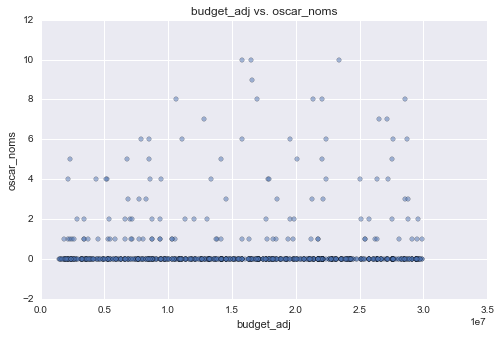

In [617]:
plot_continuous('budget_adj', 'oscar_noms', train)

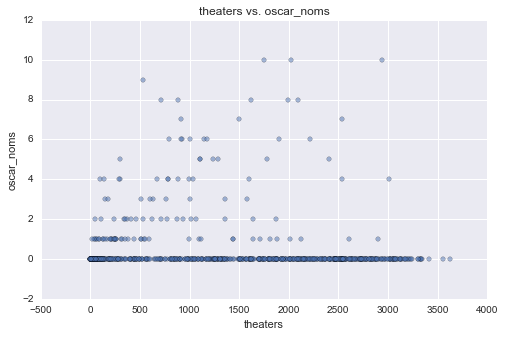

In [624]:
plot_continuous('theaters', 'oscar_noms', train)

In [1004]:
# original
oscars = smf.ols(formula="oscar_noms ~ new_genre + rating + season + theaters + runtime_mins", data = train).fit()
oscars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             oscar_noms   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     7.616
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           1.30e-26
Time:                        16:08:31   Log-Likelihood:                -1414.4
No. Observations:                 884   AIC:                             2887.
Df Residuals:                     855   BIC:                             3025.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -1.6605      0.519     -3.202      0.001        -2.678    -0.642
new_genre[T.Animation]          0.6488      0.392      1.653      0.099        -0.121     1.419
new_genre[T.Comedy]             0.1982      0.201      0.984      0.325        -0.197     0.594
new_genre[T.Crime_Thriller]     0.3077      0.233      1.321      0.187        -0.150     0.765
new_genre[T.Documentary]        0.3929      0.402      0.978      0.328        -0.396     1.182
new_genre[T.Drama]              0.7562      0.217      3.491      0.001         0.331     1.181
new_genre[T.Family]             0.3594      0.340      1.058      0.290        -0.307     1.026
new_genre[T.Fantasy_Scifi]      0.2031      0.302      0.672      0.502        -0.390     0.796
new_genre[T.Foreign]            1.0944      0.317      3.457      0.001         0.473     1.716
new_genre[T.Historical]         0.9917      0.272      3.649      0.000         0.458     1.525
new_genre[T.Horror]            -0.1448      0.222     -0.651      0.515        -0.581     0.292
new_genre[T.Musical]            0.2071      0.319      0.650      0.516        -0.418     0.832
new_genre[T.None]               0.2081      0.268      0.776      0.438        -0.318     0.734
new_genre[T.Other]              0.0253      0.734      0.034      0.972        -1.415     1.466
new_genre[T.Romance]            0.2582      0.232      1.114      0.266        -0.197     0.713
new_genre[T.Sports]             0.5579      0.341      1.638      0.102        -0.111     1.226
new_genre[T.War]                2.8364      0.641      4.423      0.000         1.578     4.095
new_genre[T.Western]            1.1259      0.580      1.943      0.052        -0.012     2.263
rating[T.NC-17]                -0.1300      0.675     -0.193      0.847        -1.455     1.195
rating[T.PG]                    0.2060      0.378      0.546      0.586        -0.535     0.947
rating[T.PG-13]                 0.4195      0.381      1.101      0.271        -0.328     1.167
rating[T.R]                     0.7007      0.382      1.833      0.067        -0.049     1.451
rating[T.Unrated]              -0.0988      0.465     -0.213      0.832        -1.011     0.814
season[T.holiday]               0.7236      0.137      5.301      0.000         0.456     0.992
season[T.spring]               -0.2579      0.127     -2.033      0.042        -0.507    -0.009
season[T.summer]               -0.0701      0.117     -0.597      0.551        -0.300     0.160
season[T.winter]               -0.2557      0.139     -1.842      0.066        -0.528     0.017
theaters                        0.0001   4.91e-05      3.009      0.003      5.14e-05     0.000
runtime_mins                    0.0093      0.003      3.431      0.001         0.004     0.015
===========

In [1009]:
# 2. optmized 
oscars_o = smf.ols(formula="oscar_noms ~ r_rating + hw_season + theaters + runtime_mins", 
                 data = train).fit()
oscars_o.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             oscar_noms   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     27.45
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           7.21e-26
Time:                        16:12:35   Log-Likelihood:                -1448.6
No. Observations:                 884   AIC:                             2909.
Df Residuals:                     878   BIC:                             2938.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -0.2698      0.303     -0.892      0.373        -0.864     0.324
r_rating[T.other]      -0.2834      0.086     -3.281      0.001        -0.453    -0.114
hw_season[T.other]     -0.9353      0.120     -7.794      0.000        -1.171    -0.700
hw_season[T.winter]    -1.1405      0.157     -7.280      0.000        -1.448    -0.833
theaters             5.833e-05   4.15e-05      1.404      0.161     -2.32e-05     0.000
runtime_mins            0.0148      0.002      6.026      0.000         0.010     0.020
==============================================================================
Omnibus:                      726.795   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14032.842
Skew:                           3.757   Prob(JB):                         0.00
Kurtosis:                      21.015   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1078]:
# 3. with log oscar_noms and theaters
oscars_log = smf.ols(formula="oscar_noms_log ~ r_rating + hw_season + theaters + runtime_mins", 
                 data = train).fit()
oscars_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         oscar_noms_log   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     32.06
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           4.60e-30
Time:                        17:24:26   Log-Likelihood:                -820.78
No. Observations:                 884   AIC:                             1654.
Df Residuals:                     878   BIC:                             1682.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -1.0698      0.149     -7.190      0.000        -1.362    -0.778
r_rating[T.other]      -0.1542      0.042     -3.633      0.000        -0.238    -0.071
hw_season[T.other]     -0.4798      0.059     -8.135      0.000        -0.596    -0.364
hw_season[T.winter]    -0.5977      0.077     -7.761      0.000        -0.749    -0.447
theaters             3.566e-07   2.04e-05      0.017      0.986     -3.97e-05  4.04e-05
runtime_mins            0.0077      0.001      6.349      0.000         0.005     0.010
==============================================================================
Omnibus:                      448.671   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2349.510
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                       9.428   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1079]:
# 4. with log oscar noms, without theaters
oscars_log2 = smf.ols(formula="oscar_noms_log ~ r_rating + hw_season + runtime_mins", 
                 data = train).fit()
oscars_log2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         oscar_noms_log   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     40.12
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           6.78e-31
Time:                        17:24:40   Log-Likelihood:                -820.78
No. Observations:                 884   AIC:                             1652.
Df Residuals:                     879   BIC:                             1675.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -1.0689      0.141     -7.600      0.000        -1.345    -0.793
r_rating[T.other]      -0.1541      0.042     -3.682      0.000        -0.236    -0.072
hw_season[T.other]     -0.4798      0.059     -8.141      0.000        -0.595    -0.364
hw_season[T.winter]    -0.5976      0.077     -7.784      0.000        -0.748    -0.447
runtime_mins            0.0077      0.001      6.494      0.000         0.005     0.010
==============================================================================
Omnibus:                      448.705   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2350.060
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                       9.429   Cond. No.                         751.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1005]:
tst = smf.ols(formula = "oscar_noms ~ new_genre", data=train).fit()
tst.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             oscar_noms   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     5.674
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           2.33e-12
Time:                        16:08:37   Log-Likelihood:                -1484.8
No. Observations:                 899   AIC:                             3006.
Df Residuals:                     881   BIC:                             3092.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       0.0426      0.186      0.229      0.819        -0.322     0.408
new_genre[T.Animation]          0.1449      0.369      0.393      0.695        -0.579     0.869
new_genre[T.Comedy]             0.2039      0.206      0.992      0.322        -0.200     0.607
new_genre[T.Crime_Thriller]     0.3653      0.237      1.544      0.123        -0.099     0.830
new_genre[T.Documentary]        0.2074      0.412      0.503      0.615        -0.602     1.017
new_genre[T.Drama]              0.8389      0.216      3.885      0.000         0.415     1.263
new_genre[T.Family]            -0.0426      0.312     -0.137      0.891        -0.654     0.569
new_genre[T.Fantasy_Scifi]      0.2167      0.308      0.704      0.482        -0.388     0.821
new_genre[T.Foreign]            1.1003      0.304      3.615      0.000         0.503     1.698
new_genre[T.Historical]         1.0938      0.267      4.090      0.000         0.569     1.619
new_genre[T.Horror]            -0.0426      0.226     -0.188      0.851        -0.486     0.401
new_genre[T.Musical]            0.2183      0.324      0.673      0.501        -0.418     0.855
new_genre[T.None]              -0.0426      0.262     -0.163      0.871        -0.556     0.471
new_genre[T.Other]             -0.0426      0.664     -0.064      0.949        -1.346     1.261
new_genre[T.Romance]            0.0890      0.237      0.376      0.707        -0.375     0.553
new_genre[T.Sports]             0.4311      0.347      1.244      0.214        -0.249     1.111
new_genre[T.War]                3.2074      0.664      4.831      0.000         1.904     4.511
new_genre[T.Western]            1.5574      0.600      2.597      0.010         0.380     2.734
==============================================================================
Omnibus:                      771.826   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16589.959
Skew:                           3.973   Prob(JB):                         0.00
Kurtosis:                      22.487   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### set up validation

In [949]:
# get model using skl
def format_skl(cat_features, cont_features, ind, data):
    '''Format df for use in skl linear regression.
    Args:
    cat_features (list) -- list of column names of categorical features
    cont_features (list) -- list of column names of continuous features
    ind (str) - name of dependent var to predict
    data (df) - dataset to use
    '''
    vals = cat_features + cont_features + [ind] # get list of all columns being used in model
    data.dropna(subset = vals, inplace = True) # drop rows with NaN in any column 
    cats = data[cat_features] # get df with categorial columns
    dummies = pd.get_dummies(cats) # get df with dummies for categorical vars 
    # need to drop one dummy for each cat -- automatically drops anything with "other" 
    keep_dummy = [c for c in dummies.columns if 'other' not in c.lower()] 
    dummies = dummies[keep_dummy]
    conts = data[cont_features]
    X = pd.concat([conts, dummies], axis=1)
    y = data[ind]
    return X, y

def regress_skl(X, y):  
    '''Fit linear regression model using skl.'''
    # fit model
    m = LinearRegression()
    m.fit(X, y)
    coefs = zip(X.columns, m.coef_)
    rsq = m.score(X, y)
    intercept = m.intercept_
    print 'rsquared: ', rsq
    print 'intercept: ', intercept
    print 'coefs: ', coefs
    return m

In [1010]:
cont_features = ['theaters', 'runtime_mins']
cat_features = ['r_rating', 'hw_season']
ind = 'oscar_noms'

In [1011]:
X, y = format_skl(cat_features, cont_features, ind, train)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1012]:
m2 = regress_skl(X, y)

rsquared:  0.135180564751
intercept:  -1.4885062651
coefs:  [('theaters', 5.8330889720850975e-05), ('runtime_mins', 0.014787553170840023), ('r_rating_R', 0.28340242127491694), ('hw_season_holiday', 0.93526276926526763), ('hw_season_winter', -0.20528240742474166)]


In [1013]:
# format validation set 
X_val, y_val = format_skl(cat_features, cont_features, ind, val)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### genres?

In [997]:
train.new_genre.value_counts()

Comedy            211
Drama             135
Horror             98
Romance            76
Crime_Thriller     76
None               48
Act_Adven          47
Historical         44
Foreign            28
Fantasy_Scifi      27
Family             26
Musical            23
Sports             19
Animation          16
Documentary        12
Western             5
War                 4
Other               4
Name: new_genre, dtype: int64

In [992]:
train.recat_genre.value_counts()

other         636
Drama         135
Act_Adven      47
Historical     44
Foreign        28
Western         5
War             4
Name: recat_genre, dtype: int64

In [994]:
val.recat_genre.value_counts()

other        63
Drama        14
Act_Adven    10
Foreign       3
Name: recat_genre, dtype: int64

In [993]:
test.recat_genre.value_counts()

other        61
Drama        26
Act_Adven     7
War           1
Name: recat_genre, dtype: int64

In [1036]:
def validate(model, X_val, y_val):
    '''Generate predicted values for validation set.
    Returns mean squared error. 
    Args:
    model -- fitted linear regression model to use for predictions
    y (var) -- name of y column
    data (df) -- validation dataset
    '''
    y_pred = model.predict(X_val)
    resid = y_val - y_pred
#     sse = sum((y_val - y_pred)**2)
#     mse = sse / len(y_val)
    mse = mean_squared_error(y_val, y_pred)
    return resid, mse

#### model 2. optimized

In [1038]:
# test cross validation set 
vresid, vmse = validate(m2, X_val, y_val)

In [1039]:
train_resid, train_mse = validate(m2, X, y)

In [1041]:
print vmse, train_mse

2.37069745617 1.55193641358


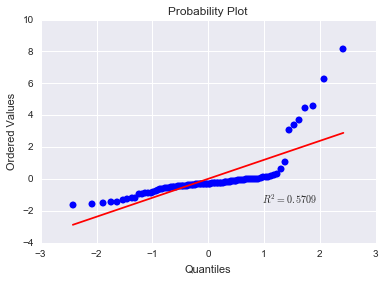

In [1043]:
# qq plot - validation set
stats.probplot(vresid, dist="norm", plot=plt)
plt.show()

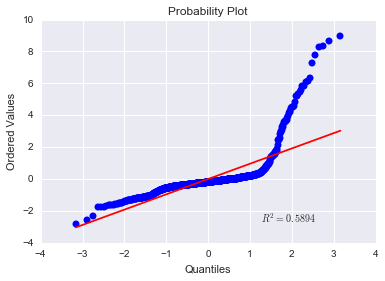

In [1044]:
stats.probplot(train_resid, dist="norm", plot=plt)
plt.show()

(array([ 17.,  64.,   2.,   0.,   1.,   2.,   2.,   0.,   1.,   1.]),
 array([-1.65329376, -0.67272643,  0.3078409 ,  1.28840823,  2.26897556,
         3.24954289,  4.23011022,  5.21067755,  6.19124488,  7.17181221,
         8.15237954]),
 <a list of 10 Patch objects>)

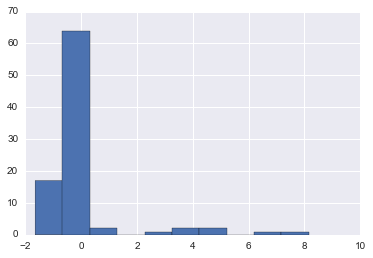

In [1049]:
plt.hist(list(vresid))

#### model 3. oscars log model with theaters

In [1063]:
# train log oscar noms model
ind_log = 'oscar_noms_log'
Xlog, ylog = format_skl(cat_features, cont_features, ind_log, train)
olog_model = regress_skl(Xlog, ylog)

rsquared:  0.154382272501
intercept:  -1.70383649117
coefs:  [('theaters', 3.5662181929102237e-07), ('runtime_mins', 0.0076582484230571669), ('r_rating_R', 0.1542264336259159), ('hw_season_holiday', 0.47984808805320261), ('hw_season_winter', -0.11783258360243239)]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1069]:
# format and test validation set
Xval, yval = format_skl(cat_features, cont_features, ind_log, val)
vresid2, vmse2 = validate(olog_model, Xval, yval)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


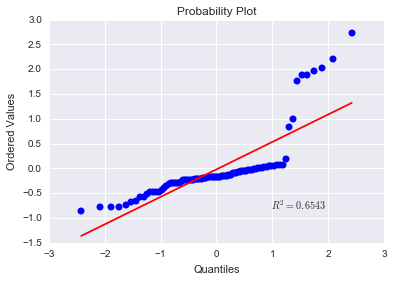

In [1068]:
stats.probplot(vresid2, dist="norm", plot=plt)
plt.show()

In [1072]:
# test on training set 
trresid2, trmse2 = validate(olog_model, Xlog, ylog)

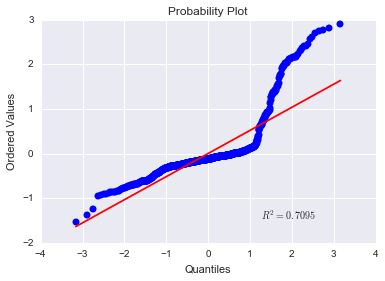

In [1073]:
stats.probplot(trresid2, dist="norm", plot=plt)
plt.show()

In [1080]:
print 'mse of training set: ', trmse2
print 'mse of validation set: ', vmse2

mse of training set:  0.374973511489
mse of validation set:  0.447831746675


#### model 4. oscars log model without theaters

In [1081]:
# X, y 
cont_features4 = ['runtime_mins']
cat_features4 = ['r_rating', 'hw_season']
ind4 = 'oscar_noms_log'

In [1084]:
# format
X_tr4, y_tr4 = format_skl(cat_features4, cont_features4, ind4, train)
X_val4, y_val4 = format_skl(cat_features4, cont_features4, ind4, val)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1085]:
model4 = regress_skl(X_tr4, y_tr4)

rsquared:  0.154381978606
intercept:  -1.7028493958
coefs:  [('runtime_mins', 0.0076538139351256494), ('r_rating_R', 0.15410500078321282), ('hw_season_holiday', 0.47982543874464745), ('hw_season_winter', -0.11776036468517434)]


In [1086]:
resid_tr4, mse_tr4 = validate(model4, X_tr4, y_tr4)
resid_val4, mse_val4 = validate(model4, X_val4, y_val4)

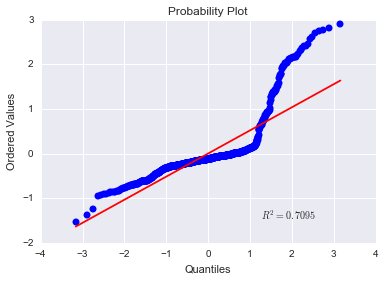

In [1089]:
stats.probplot(resid_tr4, dist="norm", plot=plt)
plt.savefig('model4-qq.png')
plt.show()

In [1087]:
print 'mse of training set: ', mse_tr4
print 'mse of validation set: ', mse_val4

mse of training set:  0.374973641812
mse of validation set:  0.447739874817


#### begin workspace for testing genre categorization

In [18]:
# original genre categories
raw_genres = tuple(by_genre.count().index)
print raw_genres

('Action', 'Action / Adventure', 'Action / Crime', 'Action Comedy', 'Action Drama', 'Action Fantasy', 'Action Horror', 'Action Thriller', 'Adventure', 'Adventure Comedy', 'Animation', 'Comedy', 'Comedy / Drama', 'Comedy Thriller', 'Concert', 'Crime', 'Crime Comedy', 'Crime Drama', 'Crime Thriller', 'Documentary', 'Drama', 'Drama / Thriller', 'Family', 'Family Adventure', 'Family Comedy', 'Fantasy', 'Fantasy Comedy', 'Fantasy Drama', 'Foreign', 'Foreign / Action', 'Foreign / Horror', 'Historical Drama', 'Historical Epic', 'Horror', 'Horror Comedy', 'Horror Thriller', 'IMAX', 'Music Drama', 'Musical', 'None', 'Period Action', 'Period Adventure', 'Period Comedy', 'Period Drama', 'Period Horror', 'Romance', 'Romantic Adventure', 'Romantic Comedy', 'Romantic Thriller', 'Sci-Fi', 'Sci-Fi Action', 'Sci-Fi Adventure', 'Sci-Fi Comedy', 'Sci-Fi Fantasy', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Sports', 'Sports Action', 'Sports Comedy', 'Sports Drama', 'Thriller', 'Unknown', 'War', 'War Drama', 'War

In [33]:
print len(raw_genres)

67


In [626]:
# code simple genres 
simple_genres = ['Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Animation', 'Comedy', 'Comedy', 'Comedy', 'Other', 
                 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 
                 'Documentary', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Foreign', 'Foreign', 'Foreign', 'Historical', 'Historical', 
                 'Horror', 'Horror', 'Horror', 'Other', 'Musical', 'Musical', 'None', 
                 'Historical', 'Historical', 'Historical', 'Historical', 'Historical', 
                 'Romance', 'Romance', 'Romance', 'Romance', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Sports', 'Sports', 'Sports', 'Sports',  'Crime_Thriller', 
                 'None', 'War', 'War', 'War', 'Western', 'Western']

In [627]:
# count how many genres
print set(simple_genres)
print len(set(simple_genres))

set(['Romance', 'None', 'Family', 'Sports', 'Horror', 'Other', 'Act_Adven', 'Foreign', 'Drama', 'Animation', 'War', 'Western', 'Historical', 'Crime_Thriller', 'Fantasy_Scifi', 'Comedy', 'Documentary', 'Musical'])
18


In [628]:
genres = dict(zip(raw_genres, simple_genres))

In [629]:
pprint(genres)

{'Action': 'Act_Adven',
 'Action / Adventure': 'Act_Adven',
 'Action / Crime': 'Act_Adven',
 'Action Comedy': 'Act_Adven',
 'Action Drama': 'Act_Adven',
 'Action Fantasy': 'Act_Adven',
 'Action Horror': 'Act_Adven',
 'Action Thriller': 'Act_Adven',
 'Adventure': 'Act_Adven',
 'Adventure Comedy': 'Act_Adven',
 'Animation': 'Animation',
 'Comedy': 'Comedy',
 'Comedy / Drama': 'Comedy',
 'Comedy Thriller': 'Comedy',
 'Concert': 'Other',
 'Crime': 'Crime_Thriller',
 'Crime Comedy': 'Crime_Thriller',
 'Crime Drama': 'Crime_Thriller',
 'Crime Thriller': 'Crime_Thriller',
 'Documentary': 'Documentary',
 'Drama': 'Drama',
 'Drama / Thriller': 'Drama',
 'Family': 'Family',
 'Family Adventure': 'Family',
 'Family Comedy': 'Family',
 'Fantasy': 'Fantasy_Scifi',
 'Fantasy Comedy': 'Fantasy_Scifi',
 'Fantasy Drama': 'Fantasy_Scifi',
 'Foreign': 'Foreign',
 'Foreign / Action': 'Foreign',
 'Foreign / Horror': 'Foreign',
 'Historical Drama': 'Historical',
 'Historical Epic': 'Historical',
 'Horror': '

#### </ end genre testing workspace >

In [93]:
pd.get_dummies(newer_movies, columns = ['genre']).head()

,1-title,2-release_date,3-closing_date,actors,budget,director,distributor,dom_total_gross,intl_total_gross,oscar_noms,...,genre_Romantic Thriller,genre_Sci-Fi Action,genre_Sci-Fi Horror,genre_Sci-Fi Thriller,genre_Sports Comedy,genre_Sports Drama,genre_Thriller,genre_Unknown,genre_War,genre_Western
123,Affliction,1998-12-30,NaT,[Willem Dafoe],6000000,[Paul Schrader],Lions Gate,6330054,NaN,2,...,0,0,0,0,0,0,0,0,0,0
200,Airplane!,1980-06-27,NaT,[Leslie Nielsen],3500000,"[Jim Abrahams, David Zucker, Jerry Zucker]",Paramount,83453539,NaN,0,...,0,0,0,0,0,0,0,0,0,0
207,Akeelah and the Bee,2006-04-28,2006-07-20,"[Laurence Fishburne, Angela Bassett, Keke Palmer]",8000000,None,Lionsgate,18848430,18948425,0,...,0,0,0,0,0,0,0,0,0,0
223,Albino Alligator,1997-01-17,1997-02-13,"[Matt Dillon, Viggo Mortensen]",6000000,None,Miramax,339379,NaN,0,...,0,0,0,0,0,0,0,1,0,0
289,All or Nothing,2002-10-25,NaT,"[Taraji P. Henson, Sally Hawkins]",9000000,[Mike Leigh],United Artists,201546,201546,0,...,0,0,0,0,0,0,0,1,0,0
